# DAG visualization


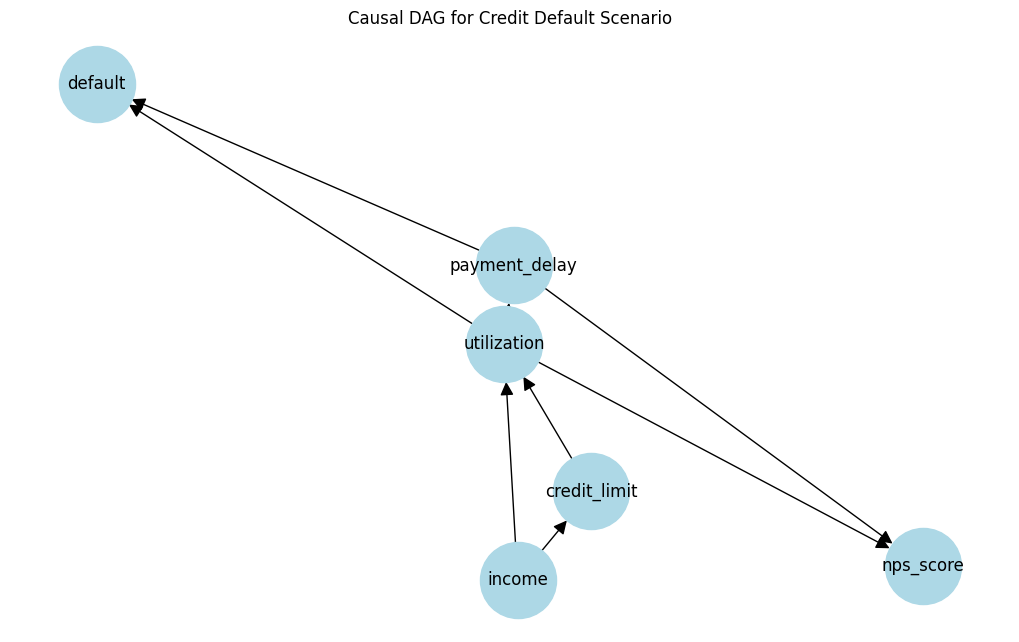

In [2]:
import networkx as nx
import matplotlib.pyplot as plt

# Define nodes and edges
nodes = ["income", "credit_limit", "utilization", "payment_delay", "nps_score", "default"]
edges = [
    ("income", "credit_limit"),
    ("credit_limit", "utilization"),
    ("income", "utilization"),
    ("utilization", "payment_delay"),
    ("payment_delay", "nps_score"),
    ("utilization", "nps_score"),
    ("utilization", "default"),
    ("payment_delay", "default"),
]

# Create a directed graph
G = nx.DiGraph()
G.add_nodes_from(nodes)
G.add_edges_from(edges)

# Position nodes for better visualization
pos = nx.spring_layout(G, seed=42)  # you can try other layouts like shell_layout

# Draw the graph
plt.figure(figsize=(10, 6))
nx.draw(G, pos, with_labels=True, node_size=3000, node_color='lightblue', arrowsize=20, font_size=12)
plt.title("Causal DAG for Credit Default Scenario")
plt.show()


# Causal effect estimation


In [15]:
import dowhy
from dowhy import CausalModel
import pandas as pd
import networkx as nx
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)

df = pd.read_csv('Simulated_Causal_Credit_Dataset.csv')
data = df.copy()

# Define causal graph as networkx DiGraph
G = nx.DiGraph()
G.add_edges_from([
    ("income", "credit_limit"),
    ("credit_limit", "utilization"),
    ("income", "utilization"),
    ("utilization", "payment_delay"),
    ("payment_delay", "nps_score"),
    ("utilization", "nps_score"),
    ("utilization", "default"),
    ("payment_delay", "default"),
])

# Convert networkx graph to dot format string
causal_graph_dot = nx.nx_pydot.to_pydot(G).to_string()

# Initialize causal model with dot string graph
model = CausalModel(
    data=data,
    treatment="credit_limit",
    outcome="default",
    graph=G  # networkx DiGraph
)


identified_estimand = model.identify_effect()

estimate = model.estimate_effect(identified_estimand,
                                 method_name="backdoor.linear_regression")

print(estimate)
print(f"Causal Effect of credit_limit on default: {estimate.value}")

refutation = model.refute_estimate(identified_estimand, estimate,
                                   method_name="placebo_treatment_refuter")
print(refutation)


*** Causal Estimate ***

## Identified estimand
Estimand type: EstimandType.NONPARAMETRIC_ATE

### Estimand : 1
Estimand name: backdoor
Estimand expression:
      d                          
──────────────(E[default|income])
d[creditₗᵢₘᵢₜ]                   
Estimand assumption 1, Unconfoundedness: If U→{credit_limit} and U→default then P(default|credit_limit,income,U) = P(default|credit_limit,income)

## Realized estimand
b: default~credit_limit+income
Target units: ate

## Estimate
Mean value: 1.961162856012333e-05

Causal Effect of credit_limit on default: 1.961162856012333e-05
Refute: Use a Placebo Treatment
Estimated effect:1.961162856012333e-05
New effect:0.0
p value:1.0



 # Refutation using placebo treatment or random common causes

In [16]:
import warnings
warnings.filterwarnings("ignore", category=RuntimeWarning)
warnings.filterwarnings("ignore", category=FutureWarning)


refutation_placebo = model.refute_estimate(
    identified_estimand, 
    estimate, 
    method_name="placebo_treatment_refuter"
)
print(refutation_placebo)

refutation_random = model.refute_estimate(
    identified_estimand,
    estimate,
    method_name="random_common_cause"
)
print(refutation_random)


Refute: Use a Placebo Treatment
Estimated effect:1.961162856012333e-05
New effect:0.0
p value:1.0

Refute: Add a random common cause
Estimated effect:1.961162856012333e-05
New effect:1.9687920979613027e-05
p value:0.8999999999999999



In [27]:
from dowhy import CausalModel
print(dir(CausalModel))


['__class__', '__delattr__', '__dict__', '__dir__', '__doc__', '__eq__', '__format__', '__ge__', '__getattribute__', '__gt__', '__hash__', '__init__', '__init_subclass__', '__le__', '__lt__', '__module__', '__ne__', '__new__', '__reduce__', '__reduce_ex__', '__repr__', '__setattr__', '__sizeof__', '__str__', '__subclasshook__', '__weakref__', 'do', 'estimate_effect', 'get_common_causes', 'get_effect_modifiers', 'get_estimator', 'get_instruments', 'identify_effect', 'init_graph', 'interpret', 'learn_graph', 'refute_estimate', 'refute_graph', 'summary', 'view_model']


In [26]:
import dowhy
print(dowhy.__version__)


0.12


In [34]:
from dowhy import CausalModel

model = CausalModel(
    data=data,
    treatment="X",
    outcome="Y",
    graph=causal_graph
)

identified_estimand = model.identify_effect()

estimate = model.estimate_effect(
    identified_estimand,
    method_name="backdoor.linear_regression"
)

print("Estimated effect:", estimate.value)

refute_results = model.refute_estimate(
    estimate=estimate,
    method_name="bootstrap_refuter",
    method_params={"num_simulations": 100}
)

print(refute_results)


Estimated effect: -0.017540978363727297


TypeError: CausalModel.refute_estimate() missing 1 required positional argument: 'estimate'